In [ ]:
import yfinance as yf
import pandas as pd
from newsapi import NewsApiClient
from datetime import datetime, timedelta

In [101]:
api_key = 'bafa54c686b64fc08d23017223d25ae2'
newsapi = NewsApiClient(api_key=api_key)

In [102]:
def get_stock_and_news_data(tickers, start_date, end_date):
    all_stock_data = []
    all_news_data = []

    for ticker in tickers:
        # Stock price data
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_data['PriceChange'] = stock_data['Close'].pct_change()
        stock_data = stock_data.dropna()
        stock_data['Movement'] = stock_data['PriceChange'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
        stock_data.index = pd.to_datetime(stock_data.index).date
        stock_data['stock'] = ticker
        all_stock_data.append(stock_data)
        
        # News headlines
        headlines = newsapi.get_everything(q=f'{ticker} stock', from_param=start_date, to=end_date, language='en', sort_by='relevancy', page_size=100)
        
        # Convert news articles to DataFrame
        headlines_df = pd.DataFrame(headlines['articles'])
        headlines_df = headlines_df[headlines_df['title'] != '[Removed]']  # Discard news with title [Removed]
        headlines_df['publishedAt'] = pd.to_datetime(headlines_df['publishedAt']).dt.date
        headlines_df['content'] = headlines_df['content'].fillna('')
        headlines_df['stock'] = ticker
        all_news_data.append(headlines_df)
    
    # Concatenate all dataframes
    stock_df = pd.concat(all_stock_data)
    news_df = pd.concat(all_news_data)
    
    return stock_df, news_df

In [103]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA"]
start_date = "2024-04-25"
end_date = "2024-05-23"

In [104]:
stock_df, news_df = get_stock_and_news_data(tickers, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_6718/2881786239.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['Movement'] = stock_data['PriceChange'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))
/var/folders/wm/c5dyqf8x7gggnw1381p0rf3m0000gn/T/ipykernel_6718/2881786239.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['stock'] = ticker
[*********************100%%*

SSLError: HTTPSConnectionPool(host='newsapi.org', port=443): Max retries exceeded with url: /v2/everything?q=MSFT+stock&from=2024-04-25&to=2024-05-23&language=en&sortBy=relevancy&pageSize=100 (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))

---

In [246]:
import pandas as pd
from eodhd import APIClient
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import re
import yfinance as yf

In [247]:
def collect_financial_news(api_key, stock_symbols, from_date, to_date, limit=100):
    client = APIClient(api_key)
    all_news_df = pd.DataFrame()
    
    for symbol in stock_symbols:
        resp = client.financial_news(s=symbol, from_date=from_date, to_date=to_date, limit=limit)
        news_df = pd.DataFrame(resp)
        news_df['symbol'] = symbol  # Aggiungi una colonna per identificare l'azione
        all_news_df = pd.concat([all_news_df, news_df], ignore_index=True)
    
    return all_news_df

In [248]:
def clean_text(text):
    # Rimozione di punteggiatura, ma mantenendo i numeri e i simboli percentuali
    text = re.sub(r'[^\w\s%]', '', text)
    # Conversione in minuscolo
    text = text.lower()
    # Rimozione di spazi extra
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [249]:
def preprocess_and_analyze_news(news_df):
    # Inizializza l'analizzatore VADER
    vader_analyzer = SentimentIntensityAnalyzer()

    # Pulizia dei titoli delle notizie
    news_df['cleaned_title'] = news_df['title'].apply(clean_text)
    
    # Calcolo del sentiment dei titoli delle notizie usando TextBlob
    news_df['sentiment_textblob'] = news_df['cleaned_title'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    # Calcolo del sentiment dei titoli delle notizie usando VADER
    news_df['sentiment_vader'] = news_df['cleaned_title'].apply(lambda x: vader_analyzer.polarity_scores(x)['compound'])
    
    # Converti i titoli delle notizie in rappresentazioni TF-IDF
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(news_df['cleaned_title'])
    
    # Aggiungi i sentimenti come caratteristiche aggiuntive
    X = scipy.sparse.hstack((X, news_df[['sentiment_textblob', 'sentiment_vader']].values))
    
    return news_df, X, vectorizer

In [266]:
def filter_weekend_news(news_df):
    # Aggiungi una colonna per il giorno della settimana
    news_df.loc[:, 'weekday'] = pd.to_datetime(news_df['date']).dt.weekday
    # Mantieni solo i giorni dal lunedì al venerdì
    filtered_news_df = news_df[news_df['weekday'] < 5].copy()
    # Rimuovi la colonna 'weekday'
    filtered_news_df.drop(columns=['weekday'], inplace=True)
    return filtered_news_df

In [250]:
api_key = '665456c26be9a2.11369205'
stock_symbols = ["AAPL.US", "MSFT.US", "GOOGL.US"]
from_date = '2024-01-01'
to_date = '2024-01-30'

all_news_df = collect_financial_news(api_key, stock_symbols, from_date, to_date)

In [267]:
filtered_news_df = filter_weekend_news(all_news_df)
news_df, X, vectorizer = preprocess_and_analyze_news(filtered_news_df)
news_df.head()

,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader
0,2024-01-30,"Dow Jones Futures: Microsoft, Google, AMD Fall On Earnings; Elon Musk Loses $56 Billion Pay Plan","Microsoft, Google and AMD earnings are a big test for AI, cloud and techs broadly. A judge struck down Elon Musk's huge pay plan.\n\nContinue reading",https://finance.yahoo.com/m/c78e3618-8015-3089-b0cc-fe9c45f6fc2a/dow-jones-futures%3A-microsoft%2C.html,"[0QYP.IL, 0R2V.IL, 0RIH.IL, A1MD34.SA, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN, AAPL.US, AAPL34.SA, ABE0.F, ABEA.F, ABEA.XETRA, ABEC.F, ABEC.STU, ABEC.XETRA, AMD.BE, AMD.DU, AMD.F, AMD.HM]",[],"{'polarity': -0.026, 'neg': 0.127, 'neu': 0.787, 'pos': 0.086}",AAPL.US,dow jones futures microsoft google amd fall on earnings elon musk loses 56 billion pay plan,-0.30000000,-0.40190000
1,2024-01-30,"Top Stock Reports for Apple, Visa &amp; Novo Nordisk","Tuesday, January 30, 2024\r\n\r\nThe Zacks Research Daily presents the best research output of our analyst team. Today's Research Daily features new research reports on 16 major stocks, including Apple Inc. (AAPL), Visa Inc. (V) and Novo Nordisk A/S (NVO). These research reports have been hand-picked from the roughly 70 reports published by our analyst team today.\r\n\r\nYou can see all of today’s research reports here >>>\r\n\r\nApple’s shares have outperformed the Zacks Computer - Mini computers industry over the past year (+33.6% vs. +33.0%). The company is benefiting from strong demand for the iPhone. Apple expects the iPhone’s year-over-year revenues to grow on an absolute basis in first-quarter fiscal 2024.\r\n\r\nRevenues for Mac are expected to significantly accelerate compared with the fourth-quarter fiscal 2023’s reported figure. It expects the year-over-year revenue growth for both iPad and Wearables, Home and Accessories to decelerate significantly from the September qu...",https://finance.yahoo.com/news/top-stock-reports-apple-visa-212900450.html,"[0R2V.IL, 3V6.F, 3V64.F, 3V64.STU, 3V64.XETRA, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN, AAPL.US, AAPL34.SA, APC.BE, APC.DU, APC.F, APC.HA, APC.HM, APC.MU, APC.STU, APC.XETRA, APC8.F]",[],"{'polarity': 1, 'neg': 0.02, 'neu': 0.796, 'pos': 0.184}",AAPL.US,top stock reports for apple visa amp novo nordisk,0.50000000,0.20230000
2,2024-01-30,3 Must-Watch Stocks Just as Unstoppable as Nvidia,"Nvidia (NASDAQ:NVDA) remains one of the hottest stocks in the market right now, with shares eeking out yet another 2.35% gain on Monday’s session. After Nvidia stock’s January jump, shares are flirting with 30% in year-to-date gains. That’s an impressive annual return, let alone one posted in under a month. As to when (or if) shares of the chip giant are bound to reverse course remains the top question on the minds of shareholders and those enjoying the Nvidia show from the sidelines.\n\nSome way or another, NVDA stock has found a way to keep pulling rabbits out of hats, something that could easily continue through 2024. Either way, Nvidia stock remains a dangerous stock to bet against amid its AI tailwind.\n\nThough momentum investors still have lots to love about Nvidia and its latest melt-up, I’d argue it’s worth checking in on other stocks that have already gained traction in recent weeks. Indeed, many such plays may be overheated after their respective rallies. However, each i...",https://finance.yahoo.com/news/3-must-watch-stocks-just-212318924.html,"[0I47.LSE, 0R2L.LSE, AAPL.US, BERK34.SA, BRH.BE, BRH.DU, BRH.F, BRH.HM, BRHF.F, BRK-A.US, BRK-B.US, BRK.NEO, BRKB.MX, BRYN.F, BRYN.XETRA, COST.MX, COST.NEO, COST.US, COWC34.SA]",[],"{'polarity': 0.998, 'neg': 0.023, 'neu': 0.841, 'pos': 0.136}",AAPL.US,3 mustwatch stocks just as unstoppable as nvidia,0.00000000,-0.20230000
3,2024-01-30,Apple Stock Sags as Analyst Forecasts Big Drop in iPhone Sales in 2024,"“Apple may have the most significant decline among the major global phone brands in 2024,” writes Ming-Chi Kuo of TF International Sec

In [268]:
def plot_sentiment_distribution(news_df):
    plt.figure(figsize=(12, 6))
    sns.histplot(news_df['sentiment_textblob'], kde=True, color='blue', label='TextBlob')
    sns.histplot(news_df['sentiment_vader'], kde=True, color='green', label='VADER')
    plt.title('Distribuzione dei Sentimenti')
    plt.xlabel('Sentiment')
    plt.ylabel('Frequenza')
    plt.legend()
    plt.show()

In [269]:
def plot_average_sentiment_per_stock(news_df):
    avg_sentiment = news_df.groupby('symbol')[['sentiment_textblob', 'sentiment_vader']].mean().reset_index()
    avg_sentiment = pd.melt(avg_sentiment, id_vars=['symbol'], value_vars=['sentiment_textblob', 'sentiment_vader'], 
                            var_name='Sentiment Type', value_name='Sentiment Score')
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg_sentiment, x='symbol', y='Sentiment Score', hue='Sentiment Type')
    plt.title('Sentimento Medio per Azione')
    plt.xlabel('Azione')
    plt.ylabel('Sentiment Medio')
    plt.legend()
    plt.show()

In [270]:
def plot_sentiment_over_time(news_df, stock_symbols):
    news_df['date'] = pd.to_datetime(news_df['date'])
    
    num_stocks = len(stock_symbols)
    cols = 2
    rows = (num_stocks // cols) + (num_stocks % cols)
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, symbol in enumerate(stock_symbols):
        stock_news = news_df[news_df['symbol'] == symbol].set_index('date')
        stock_news = stock_news[['sentiment_textblob', 'sentiment_vader']].resample('D').mean().reset_index()
        
        axes[i].plot(stock_news['date'], stock_news['sentiment_textblob'], label='TextBlob', color='blue')
        axes[i].plot(stock_news['date'], stock_news['sentiment_vader'], label='VADER', color='green')
        axes[i].set_title(f'Sentiment Over Time for {symbol}')
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Sentiment')
        axes[i].legend()
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

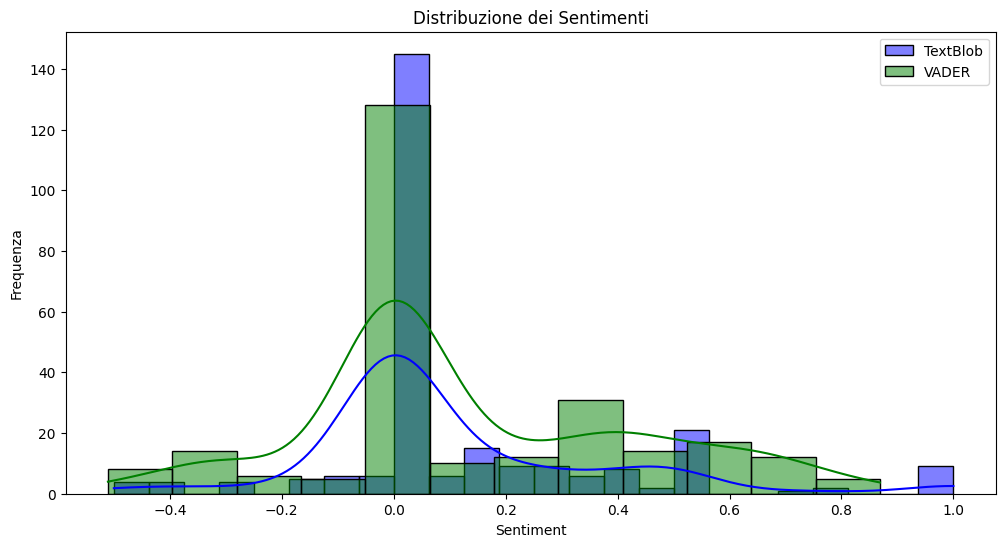

In [271]:
plot_sentiment_distribution(news_df)

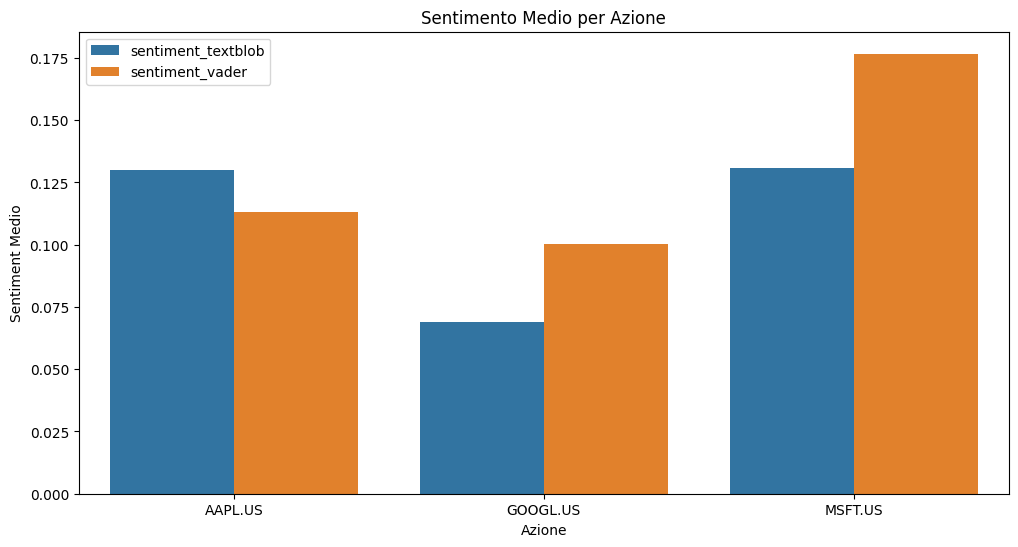

In [272]:
plot_average_sentiment_per_stock(news_df)

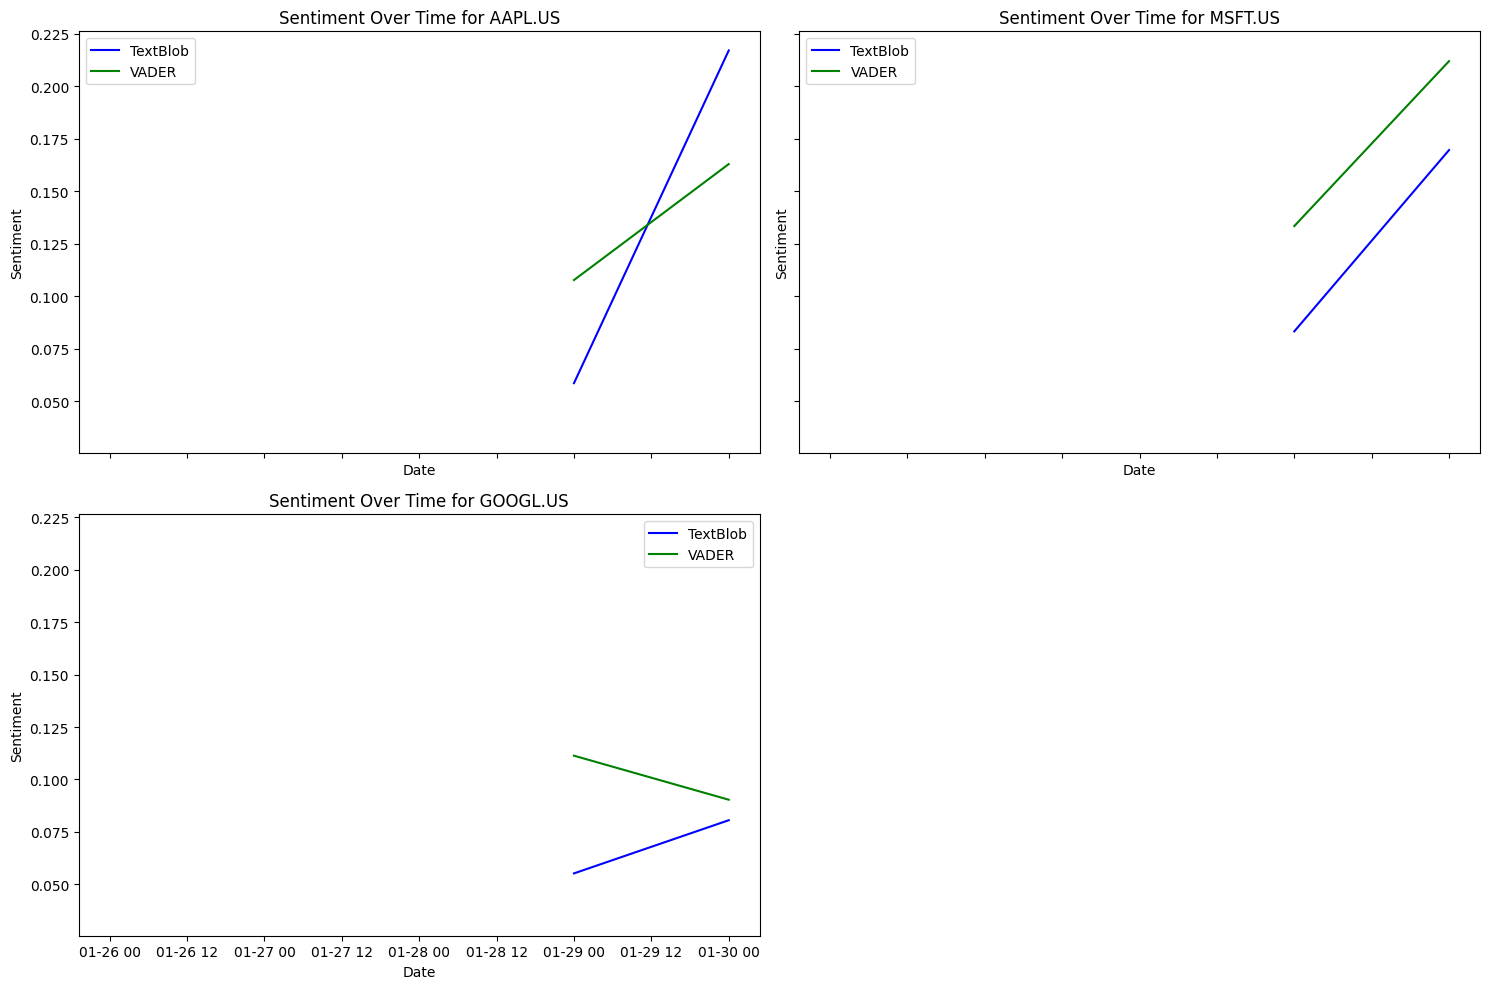

In [273]:
plot_sentiment_over_time(news_df, stock_symbols)

## 3. Gathering financial information

In [274]:
def collect_stock_prices_yfinance(stock_symbols, from_date, to_date):
    all_prices_df = pd.DataFrame()
    for symbol in stock_symbols:
        stock_symbol = symbol.split('.')[0]  # Rimuovere il suffisso ".US"
        stock_data = yf.download(stock_symbol, start=from_date, end=to_date)
        stock_data['symbol'] = symbol  # Riaggiungere il suffisso ".US"
        stock_data.reset_index(inplace=True)
        all_prices_df = pd.concat([all_prices_df, stock_data], ignore_index=True)
    return all_prices_df

In [275]:
def calculate_price_changes(prices_df):
    prices_df['Date'] = pd.to_datetime(prices_df['Date'])
    prices_df = prices_df.sort_values(by=['symbol', 'Date'])
    prices_df['price_change'] = prices_df.groupby('symbol')['Close'].pct_change()
    return prices_df

In [280]:
def merge_news_and_prices(news_df, prices_df):
    news_df['date'] = pd.to_datetime(news_df['date']).dt.date
    prices_df['Date'] = pd.to_datetime(prices_df['Date']).dt.date
    
    # Identificazione delle date mancanti
    missing_dates = set(news_df['date'].unique()) - set(prices_df['Date'].unique())
    print("Date mancanti nei dati finanziari:", missing_dates)
    
    # Filtra le notizie per escludere le date mancanti
    news_df = news_df[~news_df['date'].isin(missing_dates)]
    
    merged_df = pd.merge(news_df, prices_df, left_on=['symbol', 'date'], right_on=['symbol', 'Date'])
    return merged_df

In [284]:
all_prices_df = collect_stock_prices_yfinance(stock_symbols, from_date, to_date)
all_prices_df.head()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume,symbol
0,2024-01-02,187.14999390,188.44000244,183.88999939,185.63999939,185.15228271,82488700,AAPL.US
1,2024-01-03,184.22000122,185.88000488,183.42999268,184.25000000,183.76593018,58414500,AAPL.US
2,2024-01-04,182.14999390,183.08999634,180.88000488,181.91000366,181.43209839,71983600,AAPL.US
3,2024-01-05,181.99000549,182.75999451,180.16999817,181.17999268,180.70399475,62303300,AAPL.US
4,2024-01-08,182.08999634,185.60000610,181.50000000,185.55999756,185.07249451,59144500,AAPL.US


In [285]:
# Calcolo delle variazioni di prezzo
all_prices_df = calculate_price_changes(all_prices_df)
all_prices_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,symbol,price_change
0,2024-01-02,187.14999390,188.44000244,183.88999939,185.63999939,185.15228271,82488700,AAPL.US,NaN
1,2024-01-03,184.22000122,185.88000488,183.42999268,184.25000000,183.76593018,58414500,AAPL.US,-0.00748761
2,2024-01-04,182.14999390,183.08999634,180.88000488,181.91000366,181.43209839,71983600,AAPL.US,-0.01270012
3,2024-01-05,181.99000549,182.75999451,180.16999817,181.17999268,180.70399475,62303300,AAPL.US,-0.00401303
4,2024-01-08,182.08999634,185.60000610,181.50000000,185.55999756,185.07249451,59144500,AAPL.US,0.02417488


In [286]:
# Fusione dei dati delle notizie e dei prezzi
merged_df = merge_news_and_prices(news_df, all_prices_df)
merged_df.head()

Date mancanti nei dati finanziari: {datetime.date(2024, 1, 30)}


,date,title,content,link,symbols,tags,sentiment,symbol,cleaned_title,sentiment_textblob,sentiment_vader,Date,Open,High,Low,Close,Adj Close,Volume,price_change
0,2024-01-29,Dow Jones Futures: Fed Meeting On Deck; AI Stock Supermicro Surges On Earnings Beat,Dow Jones futures: The stock market surged Monday ahead of the two-day Fed meeting. AI stock Supermicro soared on an earnings beat.\n\nContinue reading,https://finance.yahoo.com/m/2ce7ff9a-a235-3445-8231-0a5c7f59f562/dow-jones-futures%3A-fed.html,"[0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN, AAPL.US, AAPL34.SA, APC.BE, APC.DU, APC.F, APC.HA, APC.HM, APC.MU, APC.STU, APC.XETRA, APC8.F, DJI.INDX, DKNG.US, GSPC.INDX, IK1.F]",[],"{'polarity': 0, 'neg': 0, 'neu': 1, 'pos': 0}",AAPL.US,dow jones futures fed meeting on deck ai stock supermicro surges on earnings beat,0.00000000,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22627258,47145600,-0.00358592
1,2024-01-29,LeddarTech's Board of Directors Appoints Sylvie Veilleux and Lizabeth Ardisana,"QUEBEC CITY, Jan. 30, 2024 /PRNewswire/ -- LeddarTech® (Nasdaq: LDTC), an automotive software company that provides patented disruptive AI-based low-level sensor fusion and perception software technology for ADAS, AD, and parking applications, today announced that its Board of Directors appointed Sylvie Veilleux and Lizabeth Ardisana to the Board, effective immediately. Ms. Veilleux will serve on the Audit Committee and Ms. Ardisana will serve on the Nominating and Corporate Governance Committee. LeddarTech - An automotive software company - Logo\n\n""We are pleased to welcome Sylvie and Liz to our board,"" said Mr. Derek Aberle, Chair of the Board. ""We look forward to benefiting from their wealth of experience in the technology and automotive sectors and their board perspectives as LeddarTech continues to promote adoption of its innovative software solutions in the large and rapidly growing ADAS/AD markets.""\n\nMs. Sylvie Veilleux is a strategic global technology leader and former C...",https://finance.yahoo.com/news/leddartechs-board-directors-appoints-sylvie-221700637.html,"[0RT6.LSE, AAPL.US, BEN.US, FRK.DU, FRK.F, FRK.MU, FRK.STU, LDTC.US]",[],"{'polarity': 0.969, 'neg': 0.051, 'neu': 0.859, 'pos': 0.09}",AAPL.US,leddartechs board of directors appoints sylvie veilleux and lizabeth ardisana,0.00000000,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22627258,47145600,-0.00358592
2,2024-01-29,Apple Q1 Earnings: Key Metrics to Watch,"It’s a highly critical week for earnings, with several mega-cap technology companies slated to reveal quarterly results. The strength of these mega-cap names has been admired by all, with many expecting positive results to keep overall market momentum flowing.\n\nPerhaps the most popular of the bunch, market leader Apple AAPL will reveal quarterly results on February 1st after the market’s close. The company has been on a solid earnings streak as of late, exceeding our consensus earnings and revenue expectations in three consecutive quarters.\n\nShares got a nice boost following its latest set of results, sparking a strong rally. Zacks Investment Research\n\nImage Source: Zacks Investment Research\n\nHow do expectations stack up heading into the release? Let’s take a quick look at headline estimates and a few key other metrics to keep an eye on within the release.\n\nHeadline Figures\n\nAnalysts have been bullish regarding the bottom line, with the $2.09 Zacks Consensus EPS Estimat...",https://finance.yahoo.com/news/apple-q1-earnings-key-metrics-215100238.html,"[AAPL.MX, AAPL.US, AAPL34.SA, APC.F, APC.XETRA]",[],"{'polarity': 0.995, 'neg': 0.021, 'neu': 0.861, 'pos': 0.118}",AAPL.US,apple q1 earnings key metrics to watch,0.00000000,0.00000000,2024-01-29,192.00999451,192.19999695,189.58000183,191.72999573,191.22627258,47145600,-0.00358592
3,2024-01-29,Stocks Pick Up Afternoon Steam To End At Day's Highs; Dow And S&amp;P Close At New Records,"All thr